# Motif K-mer Analysis

In [305]:
### header ###
__author__ = "Jenhan Tao"
__license__ = "BSD"
__email__ = ".jenhantao@gmail.com"

### imports ###
import sys
import os
import pandas as pd
import numpy as np
import argparse
import matplotlib
import itertools
import scipy
import matplotlib.pyplot as plt 
import seaborn as sns
import pickle
import sklearn
from sklearn import preprocessing
import multiprocessing
import threading
from collections import Counter
import time
from sklearn import decomposition
### notebook specific configuration ###
%matplotlib inline
sys.path.append("/home/jtao/code/seq_merge_pipe/")
matplotlib.pylab.rcParams['savefig.dpi'] = 200
sys.setrecursionlimit(3000)
os.chdir('/gpfs/data01/glasslab/home/jtao/analysis/kmer_analysis/')
sns.set_context('notebook')
%load_ext autoreload
%autoreload 2
%env PATH=/gpfs/data01/glasslab/home/jtao/perl5/bin:/gpfs/data01/glasslab/home/jtao/software/anaconda3/bin:/home/jtao/software/bin:/usr/local/sbin:/usr/sbin:/usr/bin:/usr/local/bin:/usr/bin:/gpfs/data01/glasslab/home/jtao/software/homer/bin:/gpfs/data01/glasslab/home/jtao/software/weblogo:/home/jtao/code/seq_merge_pipe:/home/vlink/mouse_strains/marge/shifting:/bioinformatics/glassutils/scripts:/bioinformatics/software/meme/bin



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
env: PATH=/gpfs/data01/glasslab/home/jtao/perl5/bin:/gpfs/data01/glasslab/home/jtao/software/anaconda3/bin:/home/jtao/software/bin:/usr/local/sbin:/usr/sbin:/usr/bin:/usr/local/bin:/usr/bin:/gpfs/data01/glasslab/home/jtao/software/homer/bin:/gpfs/data01/glasslab/home/jtao/software/weblogo:/home/jtao/code/seq_merge_pipe:/home/vlink/mouse_strains/marge/shifting:/bioinformatics/glassutils/scripts:/bioinformatics/software/meme/bin


## Copy Data 

In [82]:
%%bash
cp /gpfs/data01/glasslab/home/jtao/analysis/random_background_analysis/summary_frame.pickle ./
cp /gpfs/data01/glasslab/home/jtao/analysis/random_background_analysis/annotation_frame.pickle ./
cp /gpfs/data01/glasslab/home/jtao/analysis/random_background_analysis/C57BL6J.fa ./
# background data
cp /gpfs/data01/glasslab/home/jtao/analysis/random_background_analysis/C57BL6J_background.fa ./C57BL6J_background.fa 


## Read in Peak and Sequence Data

In [376]:
summary_frame = pd.read_pickle('summary_frame.pickle')
annotation_frame = pd.read_pickle('annotation_frame.pickle')
### read in sequences as dictionary {peakID: sequence}
with open('./C57BL6J.fa') as f:
    data = f.readlines()

target_sequence_dict = {}
for line in data:
    if line[0] == '>':
        sequenceName = line.strip()[1:]
    else:
        target_sequence_dict[sequenceName] = line.strip().upper()  

## read in background sequences
with open('./C57BL6J_background.fa') as f:
    data = f.readlines()
background_sequence_dict = {}
for line in data:
    if line[0] == '>':
        sequenceName = line.strip()[1:]
    else:
        background_sequence_dict[sequenceName] = line.strip().upper()[:200]
intersecting_ids = set(target_sequence_dict.keys()).intersection(set(background_sequence_dict.keys()))
for iid in intersecting_ids:
    del background_sequence_dict[iid]

## Read in Motifs

### convert MEME motif database text file into individual motifs



In [4]:
converted_motifs_dir = './individual_motifs/'
if not os.path.isdir(converted_motifs_dir):
    os.mkdir(converted_motifs_dir)
else:
    for f in os.listdir(converted_motifs_dir):
        os.remove(converted_motifs_dir + '/' + f)
        
with open('JASPAR_CORE_2016_vertebrates.meme') as f:
    data = f.readlines()
    
currentLines = [data[9]]
for line in data[9:]:
    if 'MOTIF' in line:
        motifName = currentLines[0].strip().split()[-1]
        outFile = open(converted_motifs_dir + '/' + motifName + '.fimo', 'w')
        outFile.write('MEME version 4.4\n\nALPHABET= ACGT\n\nstrands: + -\n\nBackground letter frequencies (from uniform background):\nA 0.25000 C 0.25000 G 0.25000 T 0.25000 ')
        for cl in currentLines:
            outFile.write(cl)
        outFile.close()
        currentLines = [line]
    else:
        currentLines.append(line)

### Read in individual Motifs

In [34]:
motif_dir = './individual_motifs/'
motif_matrix_dict = {}
for mf in os.listdir(motif_dir):
    with open(motif_dir + '/' + mf) as f:
        data = f.readlines()
    motif_name = data[7].strip().split()[-1]
    freqs = []
    for pwm_line in data[10:-3]:
        tokens = pwm_line.strip().split('\t')
        freqs.append([float(x.strip()) for x in tokens])
    
    motif_matrix_dict[motif_name] = freqs
    

## Construct K-mers

In [91]:
# size of biggest motif
max_size = np.max([len(motif_matrix_dict[x]) for x in motif_matrix_dict.keys()])

In [215]:
threshold = 0.3
z_threshold = 2.0
pos_nuc_dict = dict(zip(range(4),['A', 'C', 'G', 'T']))
max_kmer_size = 10
total_possible_list = []
num_observed_list = []
num_significant_list = []
k_list = []
for kmer_target_length in range(1,max_kmer_size+1):
    print('looking at ' + str(kmer_target_length)+'-mers')
    num_possible = np.power(4,kmer_target_length)
    total_possible_list.append(num_possible)
    k_list.append(kmer_target_length)
    kmers = []
    for motif_name in sorted(motif_matrix_dict.keys()):
        current_motif = motif_matrix_dict[motif_name]
        current_nucs = []
        kmer_length = np.min([len(current_motif), kmer_target_length])
        for pwm_pos in range(len(current_motif)):
            significant_nucs = []
            current_freqs = current_motif[pwm_pos]
            if current_freqs[0] >= threshold:
                significant_nucs.append('A')
            if current_freqs[1] >= threshold:
                significant_nucs.append('C')
            if current_freqs[2] >= threshold:
                significant_nucs.append('G')
            if current_freqs[3] >= threshold:
                significant_nucs.append('T')
            current_nucs.append(significant_nucs)
            if len(current_nucs) == kmer_length:
                current_kmers = itertools.product(*current_nucs)
                for km in current_kmers:
                    kmers.append(''.join(km))
                current_nucs = current_nucs[1:] # increment sliding window
    numObserved = len(set(kmers))
    motif_counts = Counter(kmers)
    count_values = list(motif_counts.values())
    zscores = scipy.stats.zscore(count_values)
    numSignificant = np.sum(zscores>=z_threshold)
    print('shapiro p-val:',scipy.stats.shapiro(count_values)[1])
    num_observed_list.append(numObserved)
    num_significant_list.append(numSignificant)

looking at 1-mers
shapiro p-val: 0.2889775037765503
looking at 2-mers
shapiro p-val: 0.04585282504558563
looking at 3-mers
shapiro p-val: 5.743105793953873e-05
looking at 4-mers
shapiro p-val: 1.0469322595851722e-16
looking at 5-mers
shapiro p-val: 3.2724102647838156e-40
looking at 6-mers
shapiro p-val: 0.0
looking at 7-mers
shapiro p-val: 0.0
looking at 8-mers
shapiro p-val: 0.0
looking at 9-mers
shapiro p-val: 0.0
looking at 10-mers
shapiro p-val: 0.0


/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/scipy/stats/morestats.py:1329: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


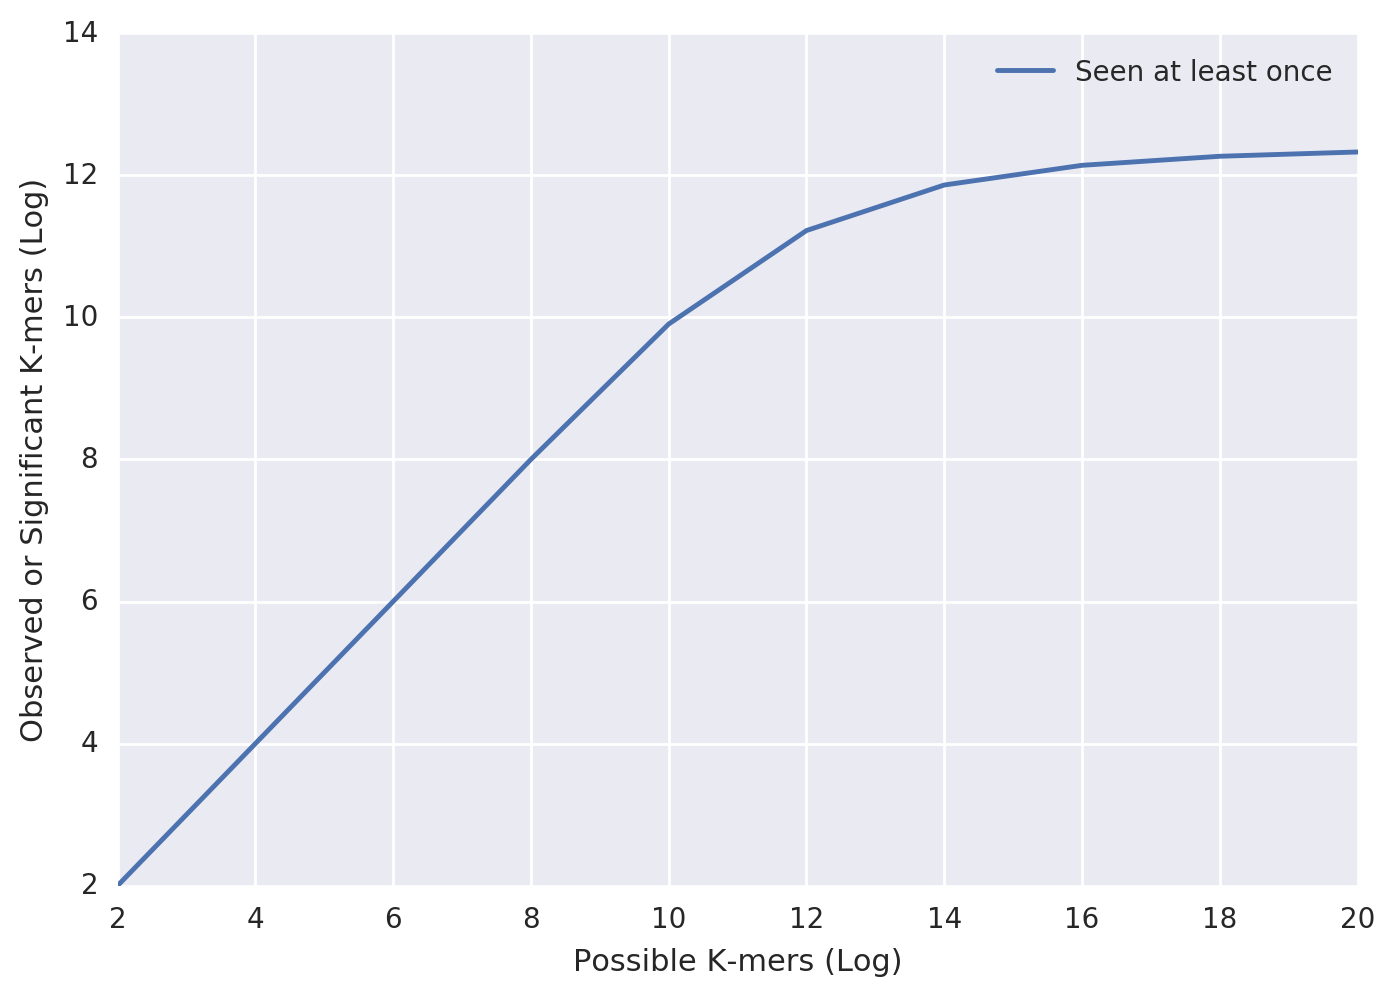

In [217]:
plt.plot(np.log2(total_possible_list), 
         np.log2(num_observed_list),
         label='Seen at least once'
            )
# plt.plot(np.log2(total_possible_list), 
#             np.log2(num_significant_list),
#             label='Signficant')
plt.legend()
plt.xlabel('Possible K-mers (Log)')
plt.ylabel('Observed or Significant K-mers (Log)')


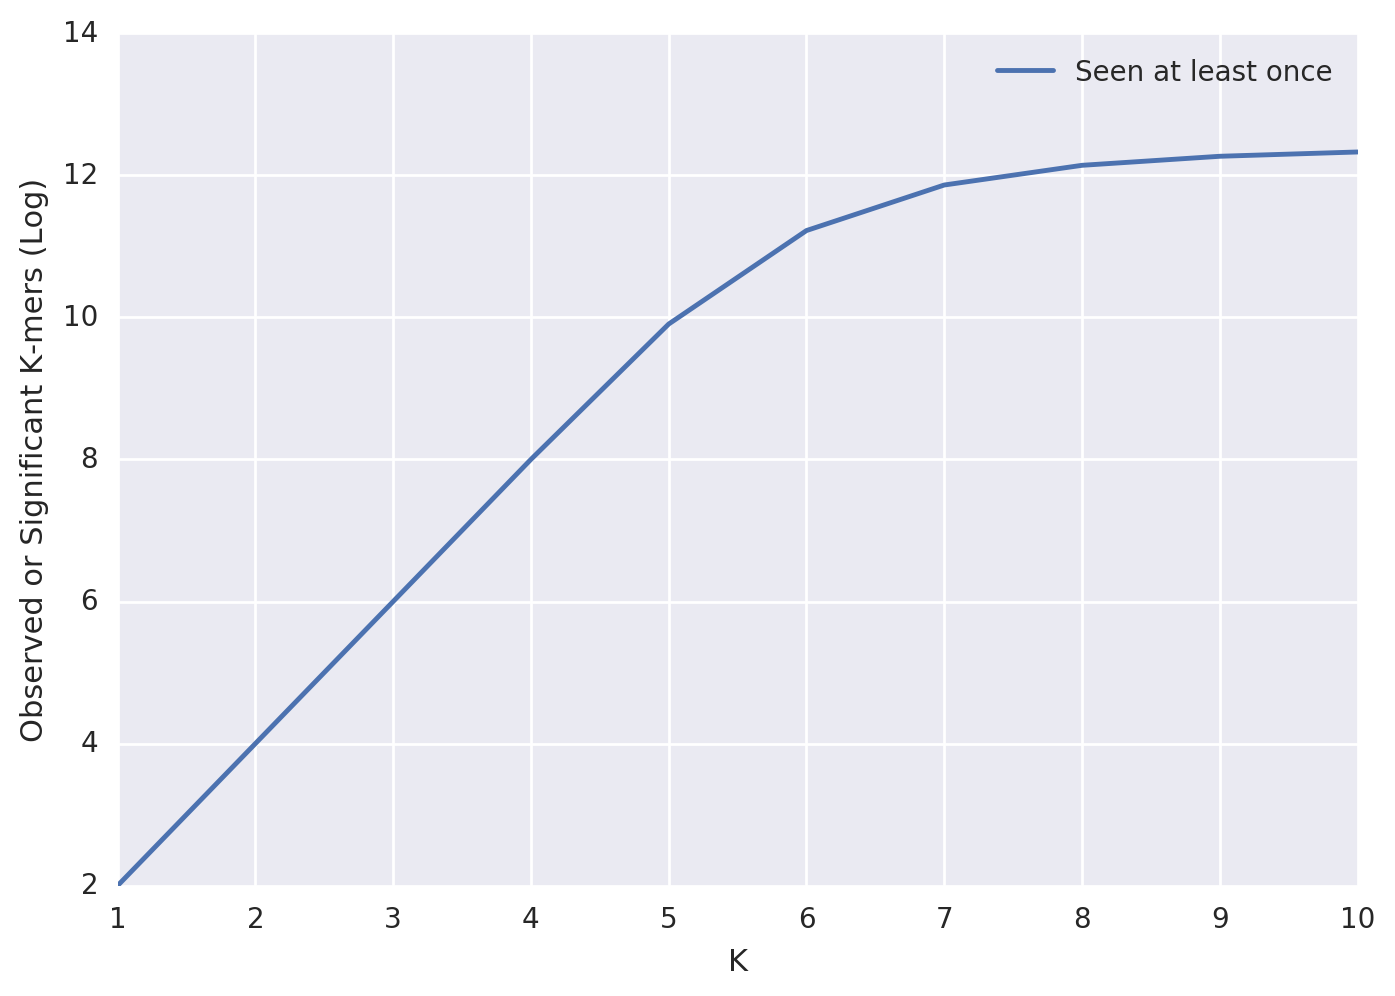

In [218]:
plt.plot(k_list, 
         np.log2(num_observed_list),
         label='Seen at least once'
            )
# plt.plot(k_list, 
#             np.log2(num_significant_list),
#             label='Signficant')
plt.legend()
plt.xlabel('K')
plt.ylabel('Observed or Significant K-mers (Log)')

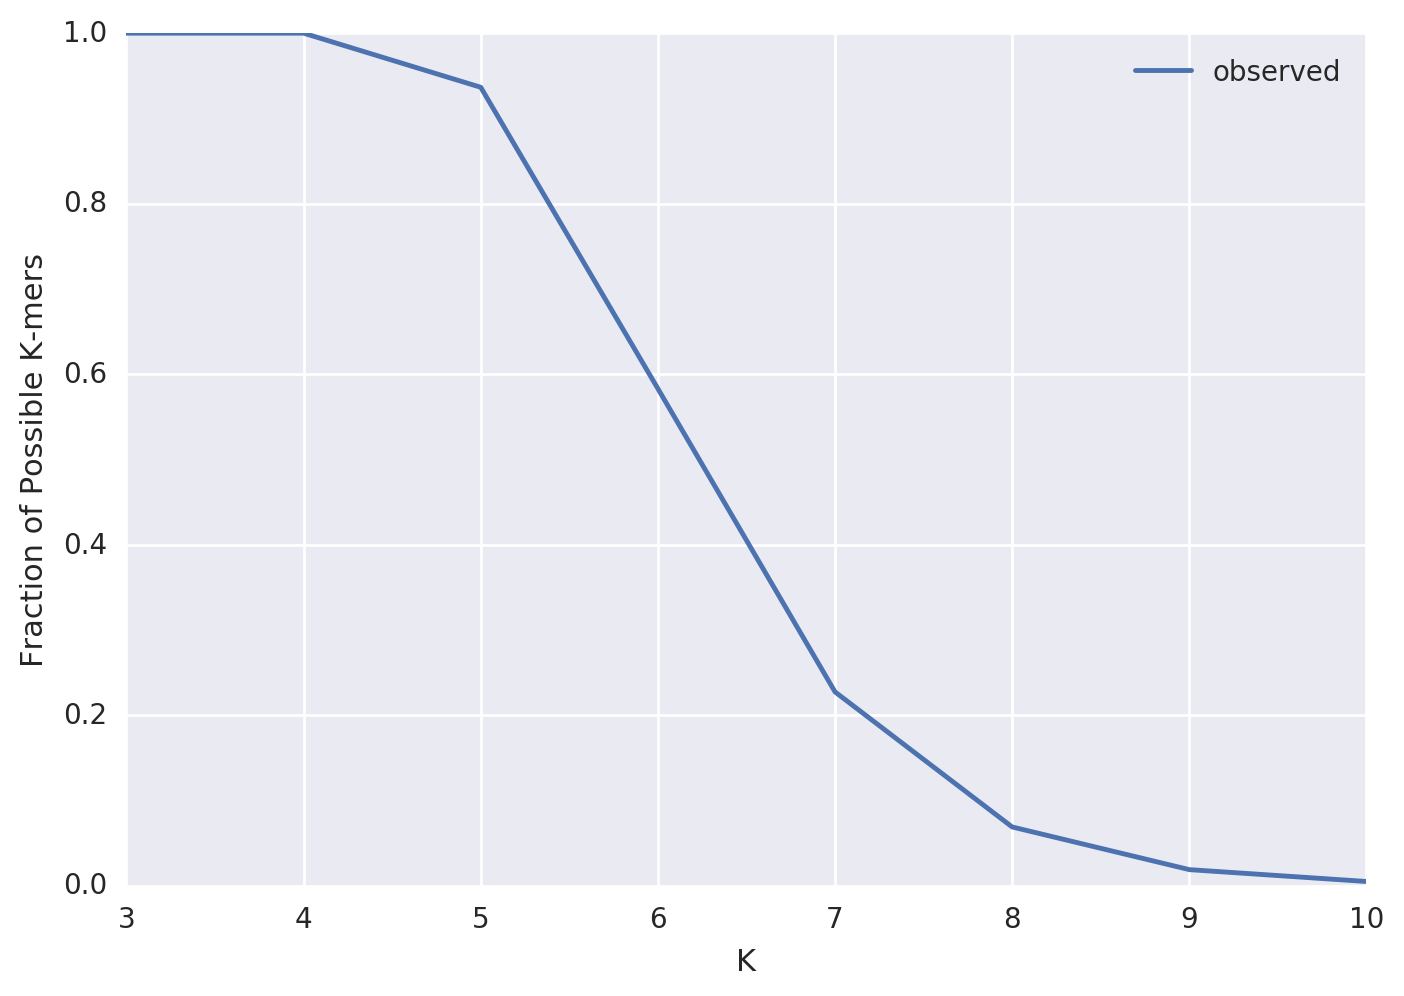

In [220]:
observed_fractions = np.array(num_observed_list)/np.array(total_possible_list)
significant_fractions = np.array(num_significant_list)/np.array(total_possible_list)
plt.plot(k_list, 
         observed_fractions,
         label='observed'
            )
# plt.plot(k_list, 
#          significant_fractions,
#          label='significant'
#             )
plt.legend()
plt.xlim(3,10)
plt.xlabel('K')
plt.ylabel('Fraction of Possible K-mers')



/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


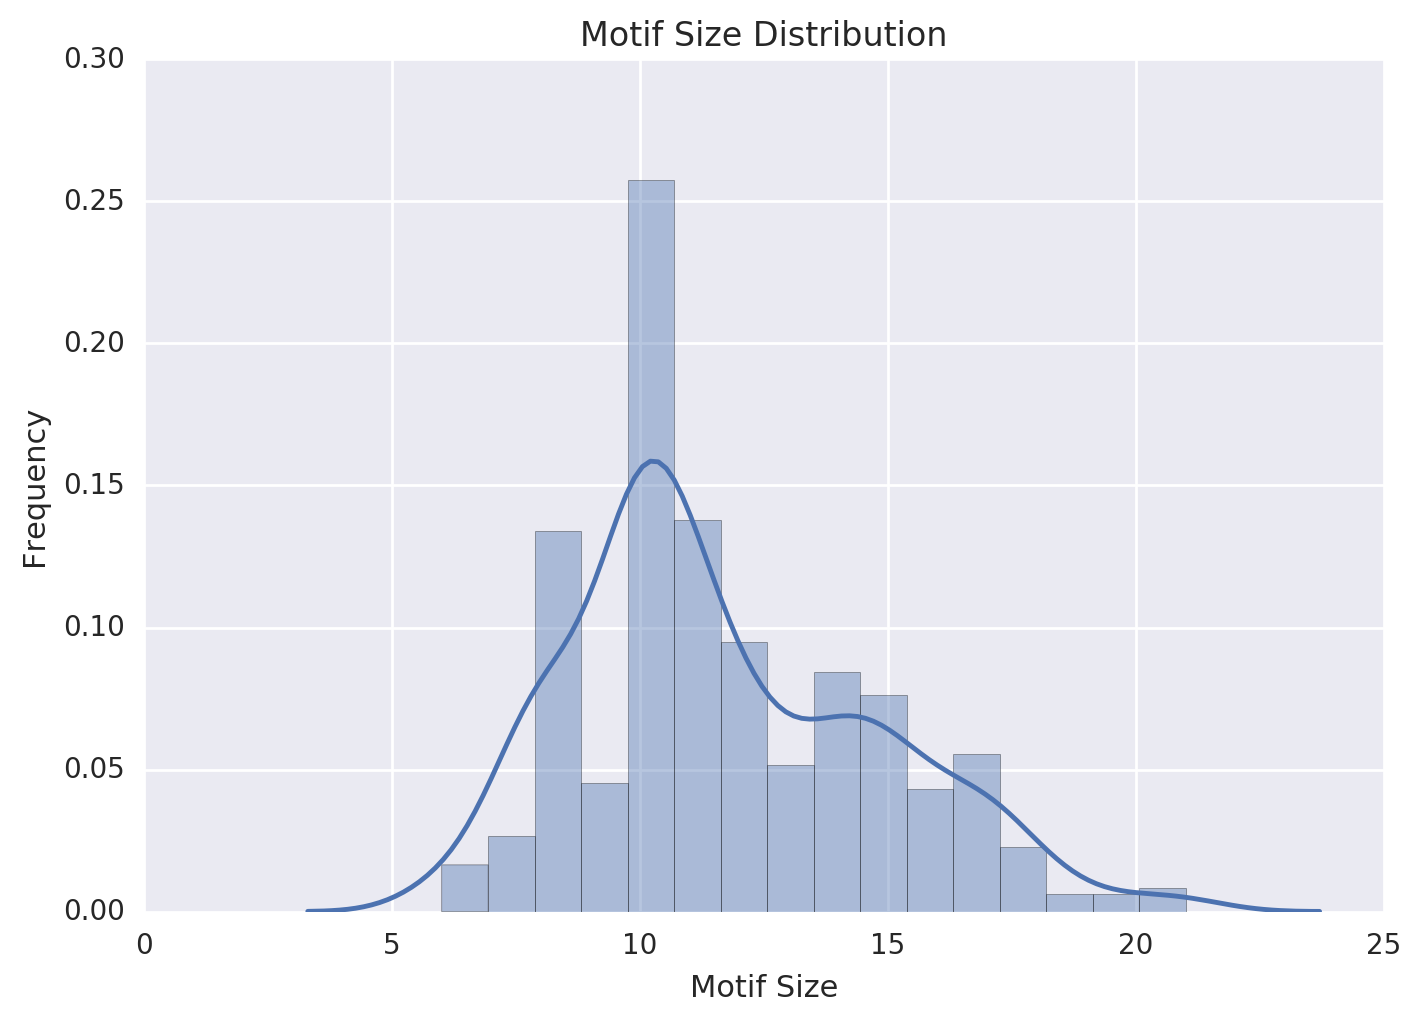

In [177]:
sns.distplot([len(motif_matrix_dict[x]) for x in motif_matrix_dict.keys()])
plt.ylabel('Frequency')
plt.xlabel('Motif Size')
plt.title('Motif Size Distribution')

## Distribution of K-mer counts

In [159]:
threshold = 0.3
pos_nuc_dict = dict(zip(range(4),['A', 'C', 'G', 'T']))
max_kmer_size = 10
count_list = []
k_list = []
normed_count_list = []
for kmer_target_length in range(1,max_kmer_size+1):
    print('looking at ' + str(kmer_target_length)+'-mers')
    num_possible = np.power(4,kmer_target_length)
    total_kmers.append(num_possible)
    k.append(kmer_target_length)
    kmers = []
    for motif_name in sorted(motif_matrix_dict.keys()):
        current_motif = motif_matrix_dict[motif_name]
        current_nucs = []
        kmer_length = np.min([len(current_motif), kmer_target_length])
        for pwm_pos in range(len(current_motif)):
            significant_nucs = []
            current_freqs = current_motif[pwm_pos]
            if current_freqs[0] >= threshold:
                significant_nucs.append('A')
            if current_freqs[1] >= threshold:
                significant_nucs.append('C')
            if current_freqs[2] >= threshold:
                significant_nucs.append('G')
            if current_freqs[3] >= threshold:
                significant_nucs.append('T')
            current_nucs.append(significant_nucs)
            if len(current_nucs) == kmer_length:
                current_kmers = itertools.product(*current_nucs)
                for km in current_kmers:
                    kmers.append(''.join(km))
                current_nucs = current_nucs[1:] # increment sliding window
    motif_counts = Counter(kmers)
    count_values = list(motif_counts.values())
    k_list = k_list + [kmer_target_length] * len(count_values)
    count_list = count_list + count_values
    normed_count_list = normed_count_list + list(scipy.stats.zscore(count_values))

looking at 1-mers
looking at 2-mers
looking at 3-mers
looking at 4-mers
looking at 5-mers
looking at 6-mers
looking at 7-mers
looking at 8-mers
looking at 9-mers
looking at 10-mers


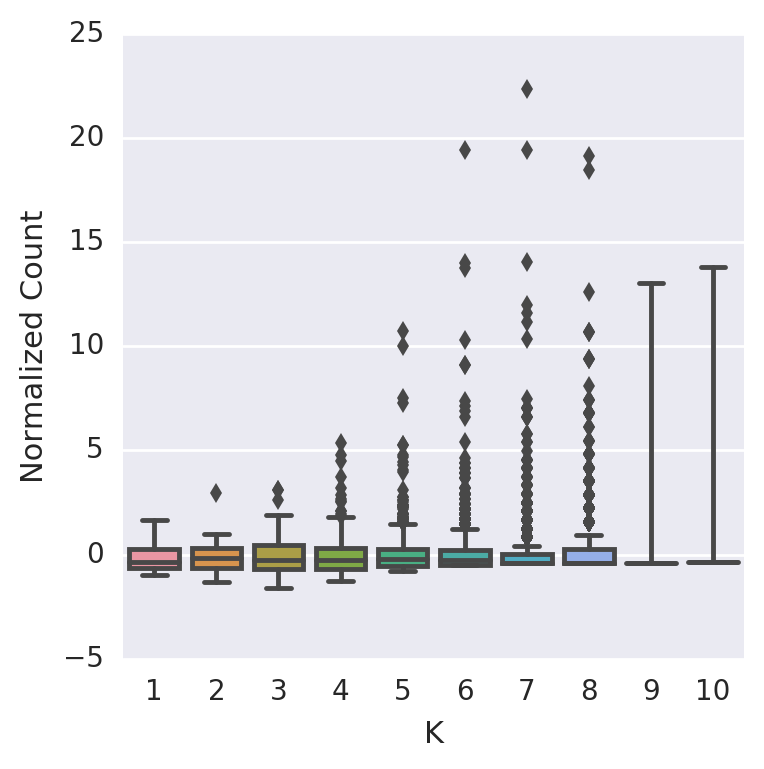

In [161]:
frame = pd.DataFrame({'K':k_list,
                     'Count':count_list,
                     'Normalized Count':normed_count_list,
                      'Log Count':np.log2(np.array(count_list) + 1)
                      })
sns.factorplot(data = frame, 
             x = 'K',
             y = 'Normalized Count',
             kind='box')

## Inferring K-mer Order Maps

In [94]:
from numba import jit

In [200]:
def calculate_orderMap(seq, 
                       k,
                       kmer_index_dict,
                       window_overlap = 0,
                       interaction_distance = 200,
                       verbose = False
                       ):
    num_kmers = len(kmer_index_dict)
    interaction_matrix = np.zeros((num_kmers,num_kmers))
    if verbose:
        print('reading', seq, len(seq))
    seenKmers = [] # ordered list of k-mers encountered
    for frame in range(k):
        if verbose:
            print('frame', frame)
        move_increment = (k - window_overlap)
        numWindows = int(np.floor((len(seq) - k - frame)/move_increment)) + 1
        if verbose:
            print('numWindows', numWindows)
        for i in range(numWindows):
            startingPos =  frame + i * move_increment
            currentKmer = seq[startingPos:startingPos + k]
            if verbose:
                print(startingPos, startingPos + k, currentKmer)
            if not 'N' in currentKmer:
                # update interaction matrix
                for skmt in seenKmers:
                    skm = skmt[0]
                    skm_start = skmt[1]
                    # if the seen k-mer follows the current k-mer
                    if skm_start < startingPos:
                        distance = startingPos - (skm_start + k)
                        if distance <= interaction_distance and distance >= ( -1 *window_overlap):
                            skm_index = kmer_index_dict[skm] # row index
                            currentKmer_index = kmer_index_dict[currentKmer] # col index
                            interaction_matrix[skm_index][currentKmer_index] +=1
                            if verbose:
                                print(skm, '->', currentKmer, distance)
                # update seenKmers
                seenKmers.append((currentKmer, startingPos))
    
    return interaction_matrix


In [377]:
@jit(nopython=False,cache=True)
def calculate_orderMap_numba(seq, 
                       k,
                       kmer_index_dict,
                       window_overlap = 0,
                       interaction_distance = 200,
                       verbose = False
                       ):
    num_kmers = len(kmer_index_dict)
    interaction_matrix = np.zeros((num_kmers,num_kmers), dtype=np.int32)
    seenKmers = None # ordered list of k-mers encountered
    for frame in range(k):
        move_increment = (k - window_overlap)
        numWindows = int(np.floor((len(seq) - k - frame)/move_increment)) + 1
        for i in range(numWindows):
            startingPos =  frame + i * move_increment
            currentKmer = seq[startingPos:startingPos + k]
            if not 'N' in currentKmer:
                # update interaction matrix
                if not seenKmers == None:
                    for skmt in seenKmers:
                        skm = skmt[0]
                        skm_start = skmt[1]
                        # if the seen k-mer follows the current k-mer
                        if skm_start < startingPos:
                            distance = startingPos - (skm_start + k)
                            if distance <= interaction_distance and distance >= ( -1 *window_overlap):
                                skm_index = kmer_index_dict[skm] # row index
                                currentKmer_index = kmer_index_dict[currentKmer] # col index
                                interaction_matrix[skm_index][currentKmer_index] +=1
                # update seenKmers
                    seenKmers.append((currentKmer, startingPos))
                else:
                    seenKmers = [(currentKmer, startingPos)]


    return interaction_matrix



In [378]:
def calculate_kmerOrderMap(id_sequence_dict, 
                           k, 
                           window_overlap = 0,
                           interaction_distance = 200,
                           verbose=False):
    ids = sorted(id_sequence_dict.keys())
    sequences = [id_sequence_dict[x] for x in ids]
    orderMaps = []
    
    # initialize kmer indices
    kmer_index_dict = {}
    counter = 0
    for kmer in itertools.product(['A', 'C', 'G', 'T'], repeat=k):
        kmer_string = ''.join(kmer)
        kmer_index_dict[kmer_string] = counter
        counter += 1
    # loop through sequences
    for seq in sequences:
        orderMap = calculate_orderMap(seq,
                                      k,
                                      kmer_index_dict,
                                      window_overlap = window_overlap,
                                      interaction_distance = interaction_distance,
                                      verbose=verbose)
        orderMaps.append(orderMap)
    return ids, orderMaps, kmer_index_dict

### Timing Tests

In [246]:
test_dict = dict(zip(range(3),['AAACCCGGGTTT', # 3-mers no overlap
                  'AAAACCCGGGTTT', # for 3-mers second frame \
                  'ATATATATATAT' # 3-mers  1 overlap
                  ]))
test_dict = dict(zip(range(1),['AAACCCGGGTTT', # 3-mers no overlap
                 
                  ]))

In [247]:
numseq_list = []
numproc_list = []
time_list = []
for numSequences in [1, 10, 100, 1000]:
    peak_indices = summary_frame[summary_frame['c57bl6_atf3_veh'] > 0.0].index.values[:numSequences]
    peak_sequences = [target_sequence_dict[x] for x in peak_indices]
    background_indices = list(background_sequence_dict.keys())[:len(peak_indices)]
    background_sequences = [background_sequence_dict[x][:numSequences] for x in background_indices]

    test_dict = dict(zip(np.concatenate([peak_indices, background_indices]),
                    np.concatenate([peak_sequences, background_sequences])))
    start = time.time()
    ids, orderMaps, kmer_index_dict = calculate_kmerOrderMap(test_dict, 
                           k=3, 
                           window_overlap = 0,
                           interaction_distance = 10,
                           verbose = False
                           )
    end = time.time()
    numseq_list.append(numSequences)
    time_list.append(end-start)
    print(end-start, numSequences)

0.005196094512939453 1
0.03336668014526367 10
0.44043636322021484 100
7.572418689727783 1000


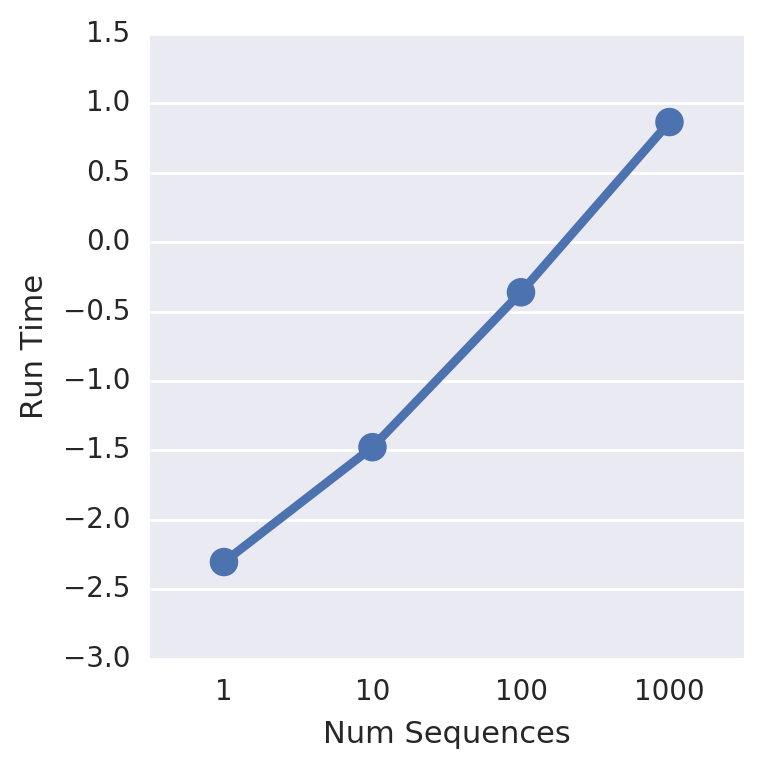

In [223]:
time_frame = pd.DataFrame({'Run Time': np.log10(np.array(time_list)),
                           'Num Sequences': numseq_list})
sns.factorplot(data = time_frame,
               x = 'Num Sequences',
               y = 'Run Time',
              )


### K=3, window_overlap=0, interaction_distance=1

In [380]:
target_ids, target_order_maps, kmer_index_dict = calculate_kmerOrderMap(target_sequence_dict, 
                           k=3, 
                           window_overlap = 0,
                           interaction_distance = 1,
                           verbose = False
                           )

current_background_sequence_dict = {x:background_sequence_dict[x] for x in list(background_sequence_dict.keys())[:len(target_sequence_dict)]}

background_ids, background_order_maps, kmer_index_dict = calculate_kmerOrderMap(current_background_sequence_dict, 
                           k=3, 
                           window_overlap = 0,
                           interaction_distance = 1,
                           verbose = False
                           )

In [431]:
# flatten maps and combine target and background sequences
flattened_dict = {}
for i in range(len(target_order_maps)):
    current_id = target_ids[i]
    flattened_dict[current_id] = target_order_maps[i].flatten()
for i in range(len(background_order_maps)):
    current_id = background_ids[i]
    flattened_dict[current_id] = background_order_maps[i].flatten()

index_kmer_dict = {kmer_index_dict[x]:x for x in kmer_index_dict}

flatIndex_transition_dict = {}
transition_flatIndex_dict = {}
counter = 0
for i in range(len(kmer_index_dict)):
    for j in range(len(kmer_index_dict)):
        kmer1 = index_kmer_dict[i]
        kmer2 = index_kmer_dict[j]
        flatIndex_transition_dict[counter] = kmer1 + '->' + kmer2
        transition_flatIndex_dict[kmer1 + '->' + kmer2] = counter
        counter += 1
        
transition_frame = pd.DataFrame(flattened_dict).T
transition_frame.columns = [flatIndex_transition_dict[x] for x in transition_frame.columns.values]

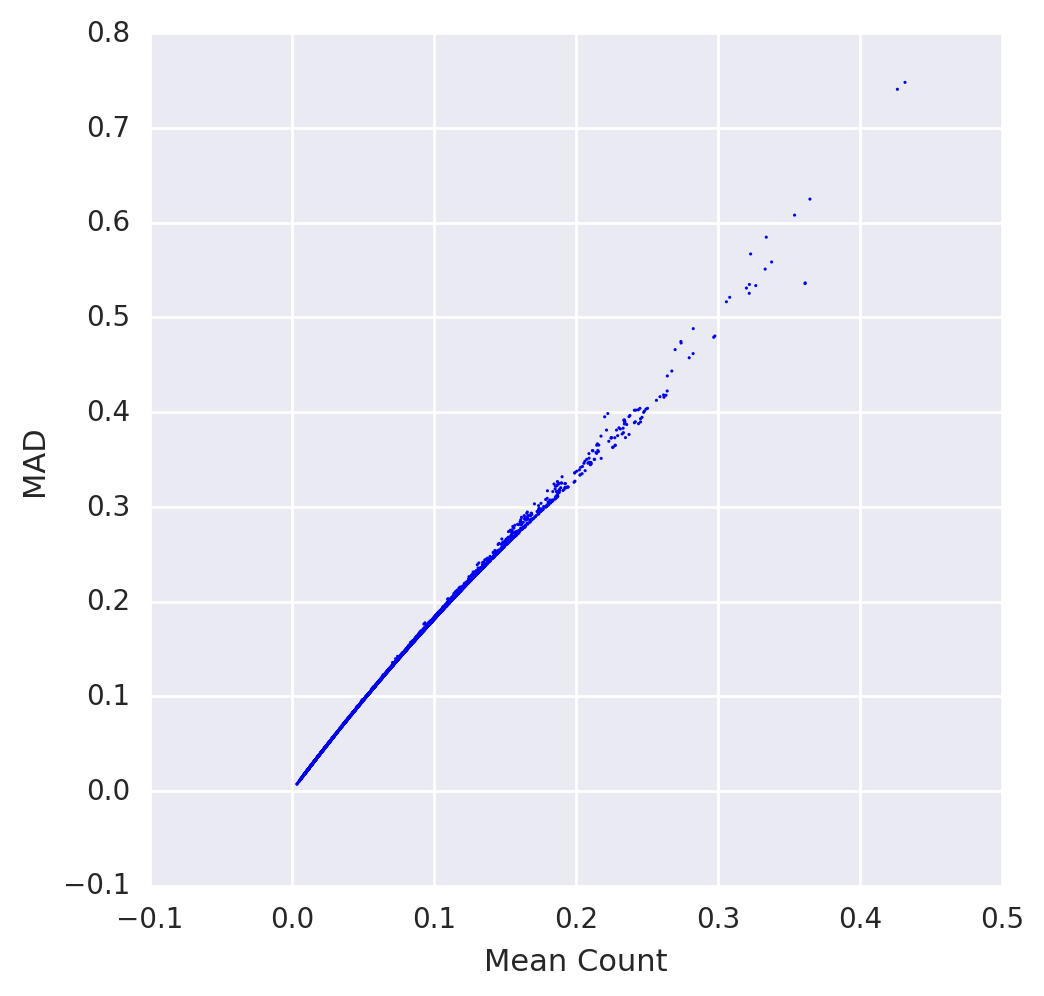

In [392]:
means = transition_frame.mean(axis=0)
mads = transition_frame.mad(axis=0)
labels = transition_frame.index.values

plt.scatter(means,
            mads,
            marker = '.',
            edgecolor = 'None',
            s = 5
           )
# for i in range(len(means)):
#     if means[i] > mads[i]:
#         plt.annotate(xy=(means[i], mads[i]), s=labels[i])
# plt.plot([0,1],[0,1])
# plt.xlim(0,1)
# plt.ylim(0,1)
plt.xlabel('Mean Count')
plt.ylabel('MAD')
ax = plt.gca()
x0,x1 = ax.get_xlim()
y0,y1 = ax.get_ylim()
ax.set_aspect(abs(x1-x0)/abs(y1-y0))
# plt.text(x=0.0, y=-0.2, s='No transition enriched when looking at entire data set - no bias', size=10)



#### PCA on all data

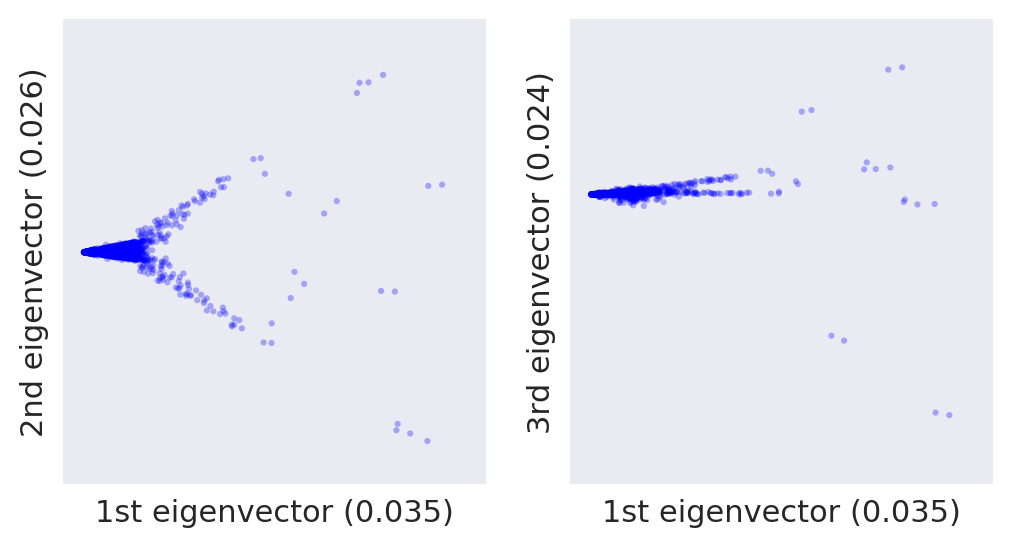

In [390]:
features = transition_frame
# colors = ['red'] * numSequences + ['blue'] * numSequences

model = sklearn.decomposition.PCA()
reduced_features = model.fit_transform(features.T)
explained_variance_ratios = model.explained_variance_ratio_

f, axs = plt.subplots(1,2, figsize=(6,3))
plt.subplot(1,2,1)  
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], s=5, c=colors, edgecolor='None', alpha=0.3)

plt.xlabel("1st eigenvector (" + "{:.3f}".format(explained_variance_ratios[0]) +')')
plt.xticks([])
plt.ylabel("2nd eigenvector (" + "{:.3f}".format(explained_variance_ratios[1]) +')')
plt.yticks([])

plt.subplot(1,2,2)  
plt.scatter(reduced_features[:, 0], reduced_features[:, 2], s=5, c=colors, edgecolor='None', alpha=0.3)
plt.xlabel("1st eigenvector (" + "{:.3f}".format(explained_variance_ratios[0]) +')')
plt.xticks([])
plt.ylabel("3rd eigenvector (" + "{:.3f}".format(explained_variance_ratios[2]) +')')
plt.yticks([])
plt.show()

#### PCA on all transitions for each factor

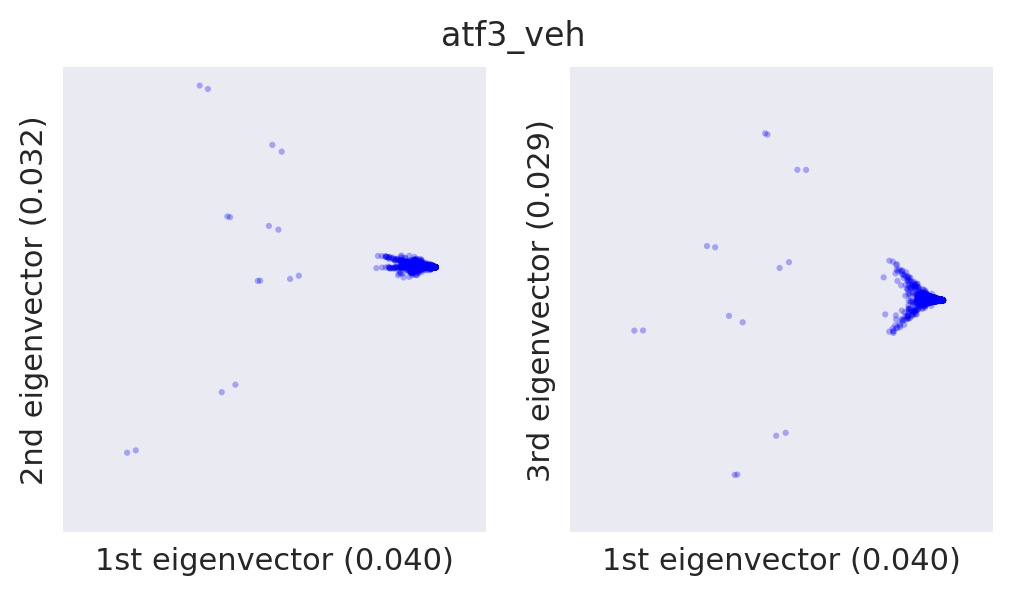

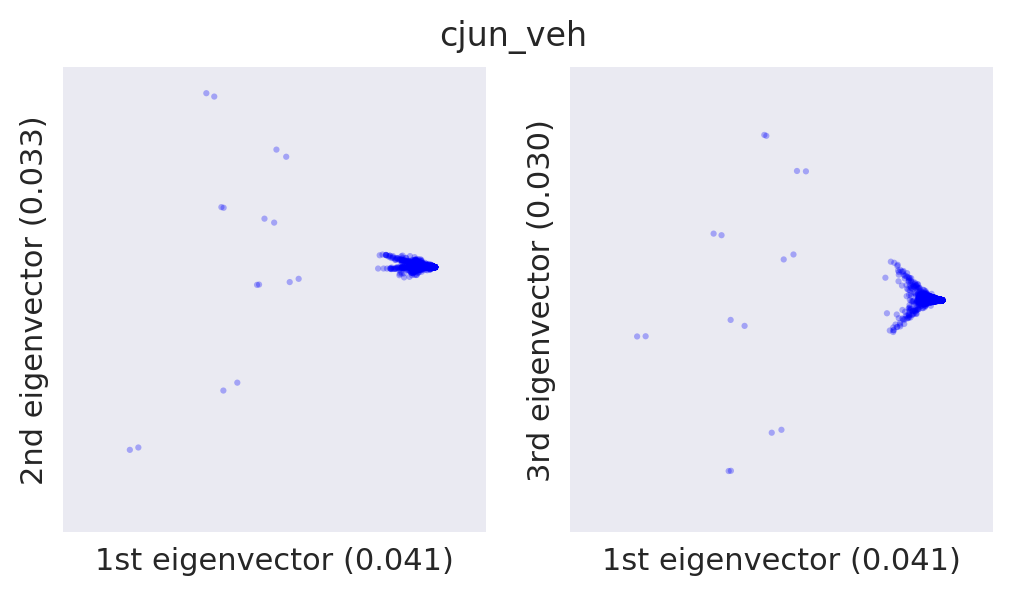

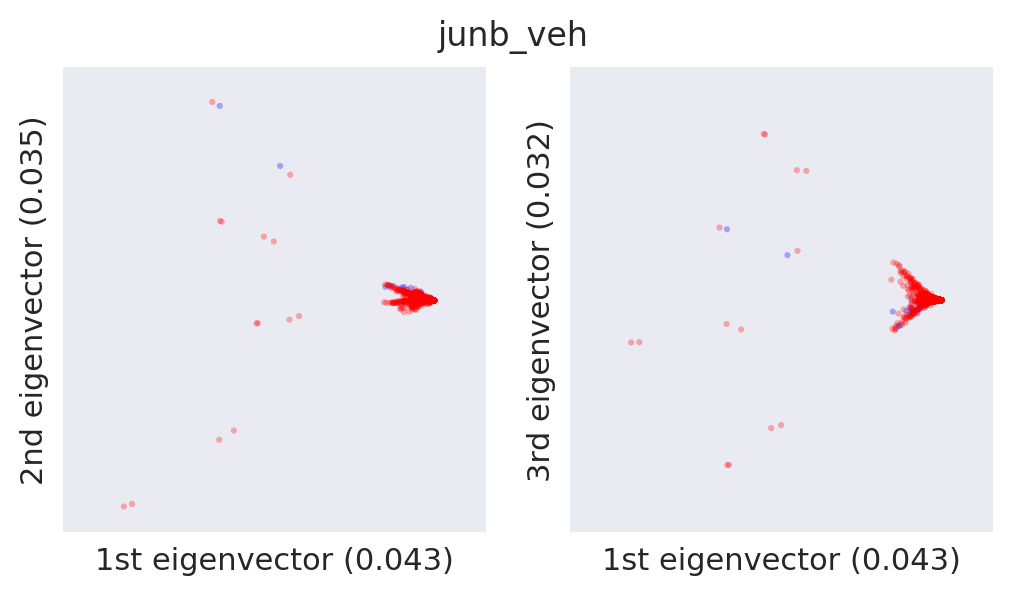

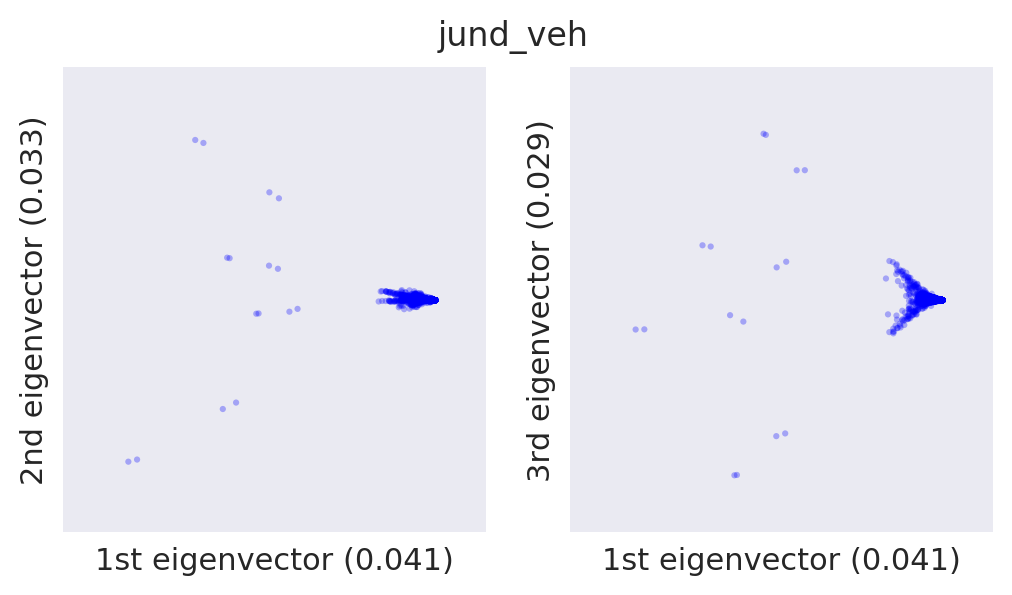

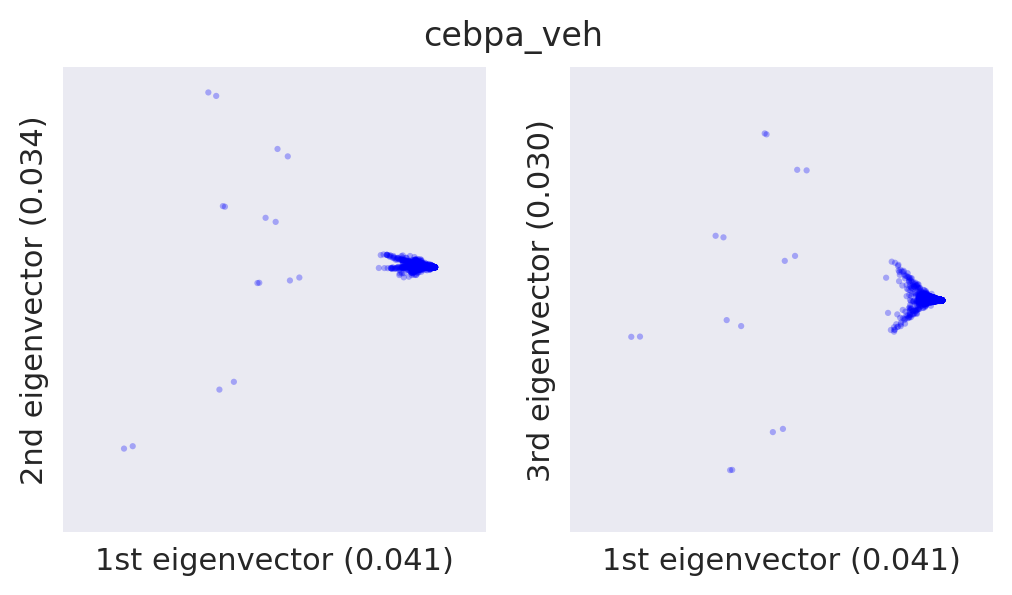

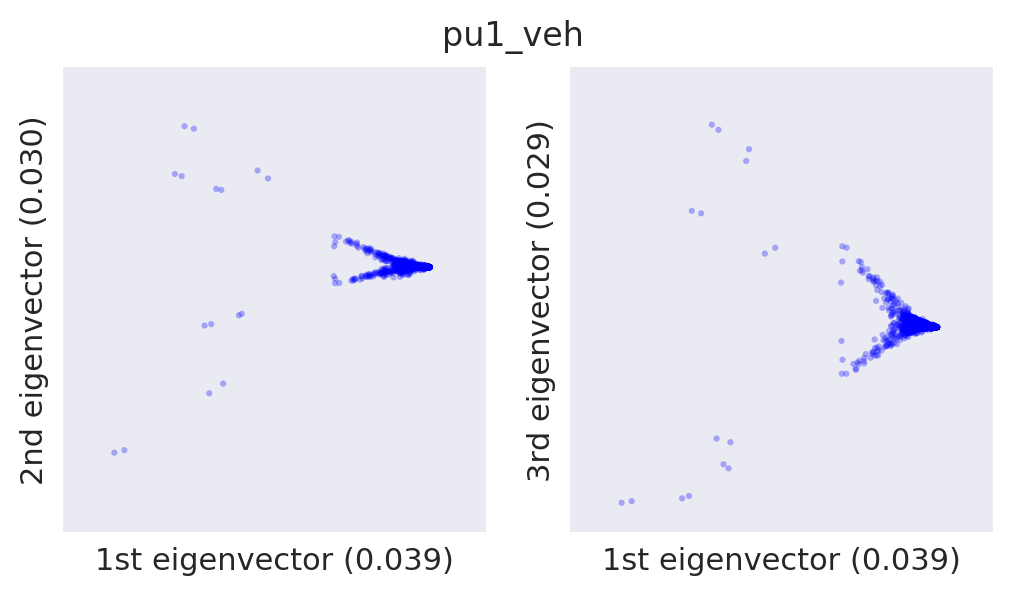

In [388]:
for factor in ['atf3', 'cjun', 'junb', 'jund', 'cebpa', 'pu1']:
    for treatment in ['veh']:
        current_target_ids = summary_frame[summary_frame['c57bl6_' + factor + '_' + treatment] > 0.0].index.values
        
        target_features = transition_frame[transition_frame.index.isin(current_target_ids)]
        background_features = transition_frame[transition_frame.index.isin(background_ids)]
        features = pd.concat([target_features, background_features])
        
        model = sklearn.decomposition.PCA()
        reduced_features = model.fit_transform(features.T)
        explained_variance_ratios = model.explained_variance_ratio_
        
        colors = ['blue' if x in target_features.index.values else 'red' for x in features.index.values]
        f, axs = plt.subplots(1,2, figsize=(6,3))
        plt.subplot(1,2,1)  
        plt.scatter(reduced_features[:, 0], reduced_features[:, 1], s=5, c=colors, edgecolor='None', alpha=0.3)

        plt.xlabel("1st eigenvector (" + "{:.3f}".format(explained_variance_ratios[0]) +')')
        plt.xticks([])
        plt.ylabel("2nd eigenvector (" + "{:.3f}".format(explained_variance_ratios[1]) +')')
        plt.yticks([])

        plt.subplot(1,2,2)  
        plt.scatter(reduced_features[:, 0], reduced_features[:, 2], s=5, c=colors, edgecolor='None', alpha=0.3)
        plt.xlabel("1st eigenvector (" + "{:.3f}".format(explained_variance_ratios[0]) +')')
        plt.xticks([])
        plt.ylabel("3rd eigenvector (" + "{:.3f}".format(explained_variance_ratios[2]) +')')
        plt.yticks([])
        plt.suptitle(factor + '_' + treatment)
        plt.show()

### Mean vs MAD comparison

In [404]:
# for each monomer in each condition, are there any transition with a mean count that exceeds the MAD?
# looks like no...
for factor in ['atf3', 'cjun', 'fos', 'junb', 'jund', 'cebpa', 'pu1']:
    for treatment in ['veh', 'kla']:
        current_target_ids = summary_frame[summary_frame['c57bl6_' + factor + '_' + treatment] > 0.0].index.values
        
        target_features = transition_frame[transition_frame.index.isin(current_target_ids)]
        background_features = transition_frame[transition_frame.index.isin(background_ids)]
        
        target_mads = target_features.mad(axis=0)
        target_means = target_features.mean(axis=0)
        
        print(np.sum(target_means > target_mads))



0
0
0
0
0
0
0
0
0
0
0
0
0
0


### Kruskal 2 sample test - factor vs random background

In [440]:
# ks two sample tests on target counts vs background counts

p_threshold = 0.01/transition_frame.shape[1]
p_threshold = 1e-100
factor_pval_dict = {}
for factor in ['atf3', 'cjun', 'fos', 'junb', 'jund', 'cebpa', 'pu1']:
    for treatment in ['veh', 'kla']:
# for factor in ['atf3']:
#     for treatment in ['veh']:
        print(factor, treatment)
        pvals = []
        current_target_ids = summary_frame[summary_frame['c57bl6_' + factor + '_' + treatment] > 0.0].index.values
        
        target_features = transition_frame[transition_frame.index.isin(current_target_ids)]
        background_features = transition_frame[transition_frame.index.isin(background_ids)]
        
        for transition in target_features.columns.values:
            target_counts = target_features[transition].values
            background_counts = background_features[transition].values
            stat, pval = scipy.stats.ks_2samp(target_counts, background_counts)
            pvals.append(pval)
            if pval < p_threshold:
                print(transition, pval)
        factor_pval_dict[factor+ '_' + treatment] = pvals
kruskal_frame = pd.DataFrame(factor_pval_dict)
kruskal_frame.index = transition_frame.columns.values


atf3 veh
ACT->TCC 1.80414804554e-304
AGG->AAG 2.09559080435e-267
AGT->CAC 1.84186416167e-128
ATG->ACT 1.7385134016e-102
CTT->CCT 1.97296380421e-269
GAC->TCA 0.0
GAG->GAA 1.68282854568e-125
GAG->TCA 0.0
GGA->AGT 1.55862253574e-294
GTG->ACT 2.31772877886e-137
TGA->CTC 2.63155226776e-303
TGA->GTC 0.0
TGA->TCA 0.0
TTC->CTC 1.70982977419e-148
atf3 kla
ACT->TCC 0.0
AGG->AAG 6.82137380115e-277
AGT->CAC 1.64605519118e-210
AGT->CAT 4.44142861287e-210
ATG->ACT 3.0901452972e-212
ATG->AGT 7.46579300435e-111
CTT->CCT 3.50411890108e-256
GAA->TGA 1.63882828918e-101
GAC->TCA 0.0
GAG->GAA 4.55047479673e-129
GAG->TCA 0.0
GGA->AGT 0.0
GTG->ACT 8.09061361945e-221
TCA->TTC 4.77789628868e-102
TGA->CTC 0.0
TGA->GTC 0.0
TGA->TCA 0.0
TTC->CTC 6.51907915325e-155
cjun veh
ACT->TCC 6.64007267837e-207
AGG->AAG 8.5038814817e-191
AGT->CAC 1.40222852052e-109
CTT->CCT 1.59937649873e-188
GAC->TCA 0.0
GAG->TCA 0.0
GGA->AGT 1.12114425468e-203
GTG->ACT 1.33945886608e-123
TGA->CTC 7.31811412398e-305
TGA->GTC 0.0
TGA->TCA 0

/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


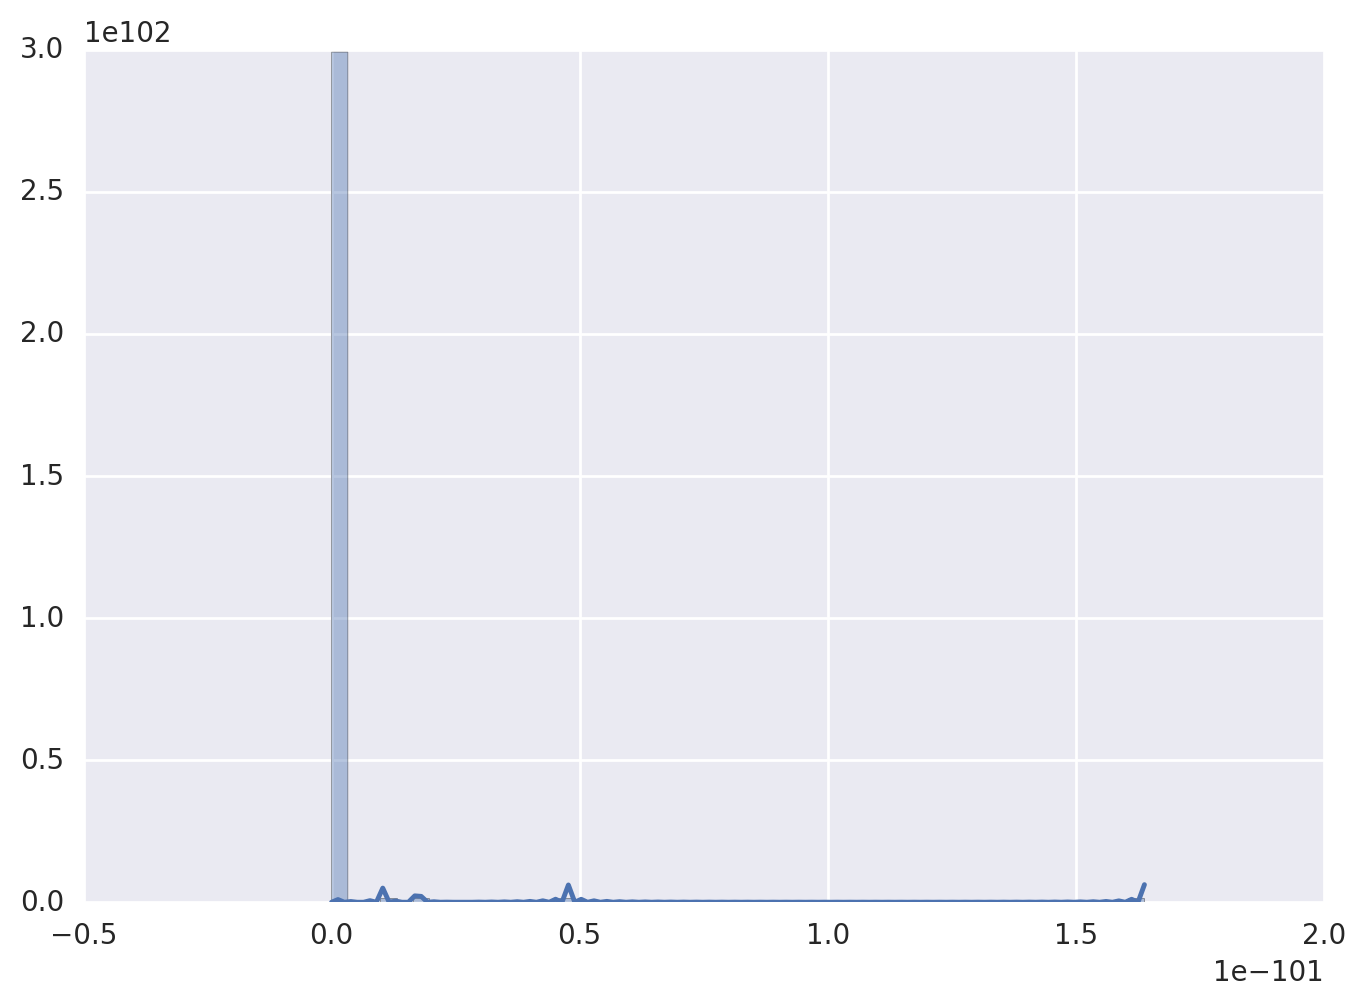

In [444]:
sns.distplot([x for x in kruskal_frame.values.flatten() if x < 1e-100])

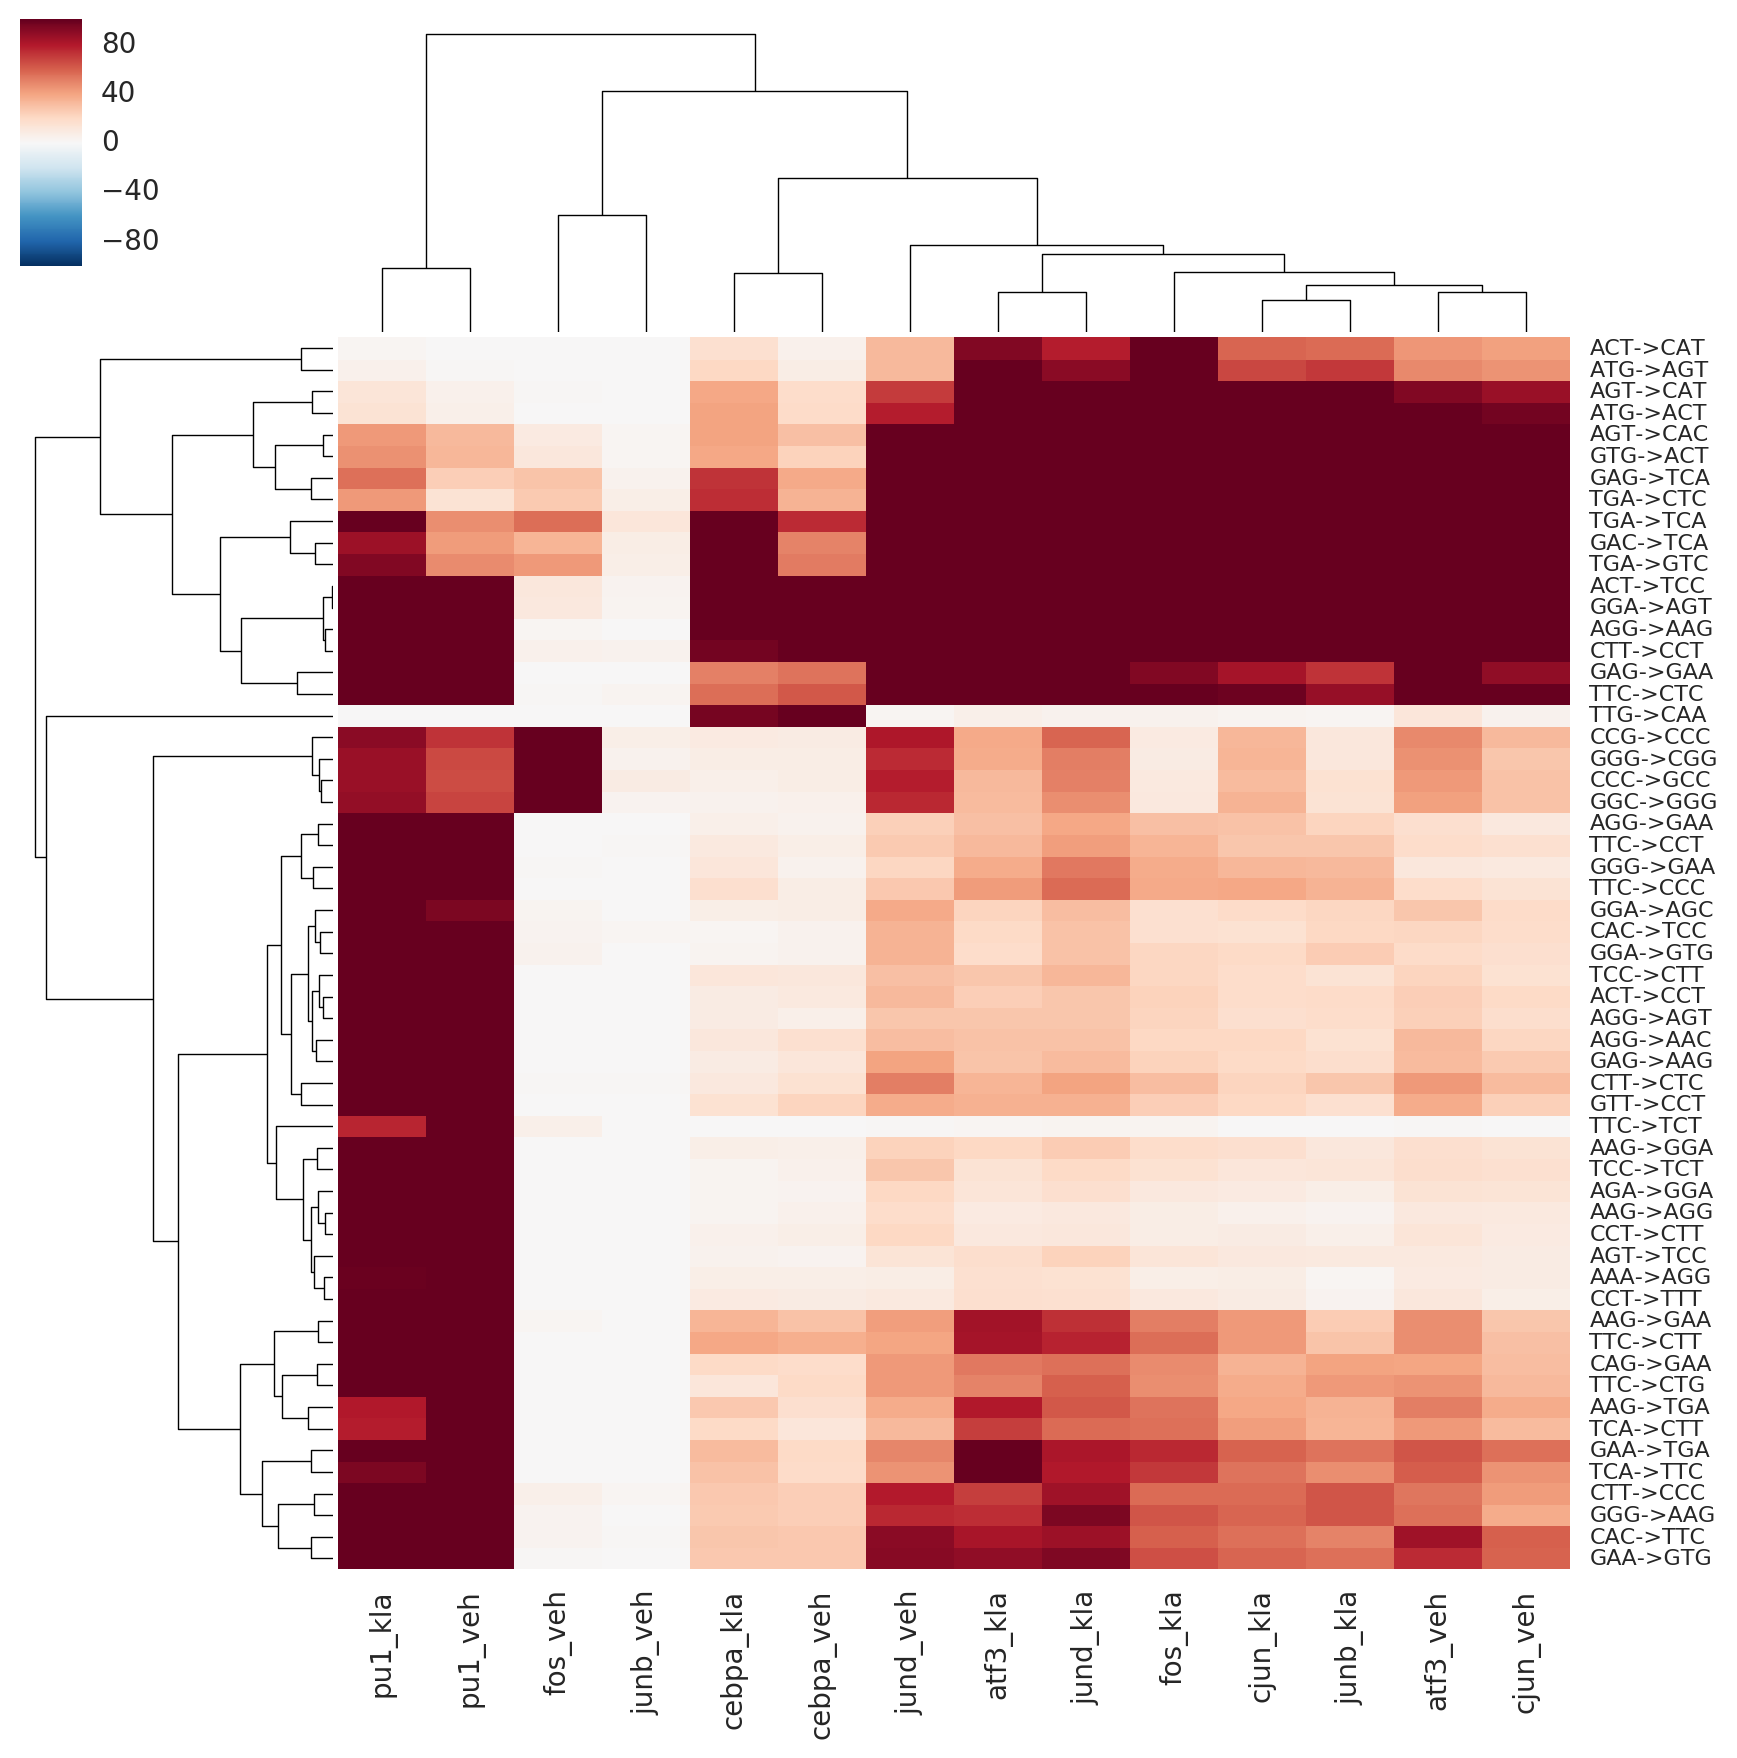

In [461]:
p_threshold = 1e-100
current_data = kruskal_frame[kruskal_frame.min(axis=1) < p_threshold]
cg = sns.clustermap(-1*np.log10(current_data + p_threshold),
               )
plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), fontsize=8, rotation=0, );

### Logistic Regression

In [463]:
# split data into GC content matched training and test data
def get_split(features, labels, test_size):
    '''
    feature: 2D array (samples x features)
    labels: 1D boolean array (samples x)
    test_size: fraction of data to test on
    '''
    
    ### match GC content of samples labelled True with those labelled False by thowing out False samples
    # retrieve sequences using index of labels
    index_label_tuples = tuple(zip(labels.index.values, labels.values))
    
    true_ids = [x[0] for x in index_label_tuples if x[1]]
    
    false_ids = [x[0] for x in index_label_tuples if not x[1]]
       
    filtered_ids = true_ids + false_ids
    filtered_features = features[features.index.isin(filtered_ids)]
    filtered_labels = labels[labels.index.isin(filtered_ids)]

    if test_size <= 0.5:
        training_indices, test_indices = next(iter(
                sklearn.cross_validation.StratifiedKFold(filtered_labels, int(1/test_size), shuffle=True)))
    else:
        test_indices, training_indices = next(
            iter(sklearn.cross_validation.StratifiedKFold(filtered_labels, int(1/(1-test_size)), shuffle=True)))
    training_ids = [filtered_ids[i] for i in training_indices]
    test_ids = [filtered_ids[i] for i in test_indices]
    
    training_features = filtered_features[filtered_features.index.isin(training_ids)]
    test_features = filtered_features[filtered_features.index.isin(test_ids)]
    training_labels = filtered_labels[filtered_labels.index.isin(training_ids)]
    test_labels = filtered_labels[filtered_labels.index.isin(test_ids)]
    
    return training_features, test_features, training_labels, test_labels
    

In [468]:
# for monomers using all motifs
numIterations = 1
test_size = 0.5
strain = 'c57bl6'
factor_coeff_dict = {}
for treatment in ['veh', 'kla']:
    for monomer in ['atf3', 'cjun', 'fos', 'junb', 'jund', 'pu1', 'cebpa']:
        start = time.time()
        target_indices = summary_frame[summary_frame[strain + '_' + monomer + '_' + treatment] > 0.0].index.values
        background_indices = background_ids    # select subset of background indices to use
                
        target_features = transition_frame[transition_frame.index.isin(target_indices)]
        background_features = transition_frame[transition_frame.index.isin(background_indices)]
        
        # merge target and background features together 
        transition_features = pd.concat([target_features, background_features])
        labels = pd.Series(data = [True] * len(target_indices) + [False] * len(background_indices),
                           index = transition_features.index.values)
        all_aucs = []
        all_coefficients = []
        all_precisions = []
        for i in range(numIterations):

            # split data into training and test sets
            training_transition_features, test_transition_features, training_labels, test_labels = get_split(
                transition_features, labels, test_size = test_size)
            #  Train affinity classifier
            transition_classifier = sklearn.linear_model.LogisticRegression(penalty='l1', n_jobs=-1)
            transition_classifier.fit(training_transition_features, training_labels)

            probas = transition_classifier.predict_proba(test_transition_features)
            # score predictions
            current_roc_auc = sklearn.metrics.roc_auc_score(test_labels, probas[:, 1], average = None)
            current_precision = sklearn.metrics.average_precision_score(test_labels, probas[:, 1], average = None)

            all_aucs.append(current_roc_auc)
            all_precisions.append(current_precision)
            current_coefficients = transition_classifier.coef_.flatten()
            all_coefficients.append(current_coefficients)
            
        end = time.time()
        mean_coefficients = np.mean(all_coefficients, axis=0)
        factor_coeff_dict[monomer + '_' + treatment] = mean_coefficients
        print(monomer + '_' + treatment,
              'roc:', np.mean(all_aucs), np.var(all_aucs),
              'precision:', np.mean(all_precisions), np.var(all_precisions),  
              'numTestPositives:', np.sum(test_labels),
              end-start
             )
        

atf3_veh roc: 0.940539790141 0.0 precision: 0.78973803739 0.0 numTestPositives: 11077 17.966949224472046
cjun_veh roc: 0.941132987466 0.0 precision: 0.715799537343 0.0 numTestPositives: 6366 24.053744554519653
fos_veh roc: 0.968929114357 0.0 precision: 0.727056848753 0.0 numTestPositives: 1000 12.580605030059814
junb_veh roc: 0.792798048212 0.0 precision: 0.131925127886 0.0 numTestPositives: 248 40.022268295288086
jund_veh roc: 0.94421460263 0.0 precision: 0.777979467408 0.0 numTestPositives: 9075 19.64804983139038
pu1_veh roc: 0.938698216542 0.0 precision: 0.852747381097 0.0 numTestPositives: 20079 28.603299379348755
cebpa_veh roc: 0.922319609849 0.0 precision: 0.640669422881 0.0 numTestPositives: 5878 21.79271388053894
atf3_kla roc: 0.938881249026 0.0 precision: 0.837746094362 0.0 numTestPositives: 17439 24.829601287841797
cjun_kla roc: 0.946437582193 0.0 precision: 0.764629079966 0.0 numTestPositives: 8110 17.646337747573853
fos_kla roc: 0.948900905713 0.0 precision: 0.790003603627 

/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/seaborn-0.7.1-py3.5.egg/seaborn/matrix.py:143: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if xticklabels == []:


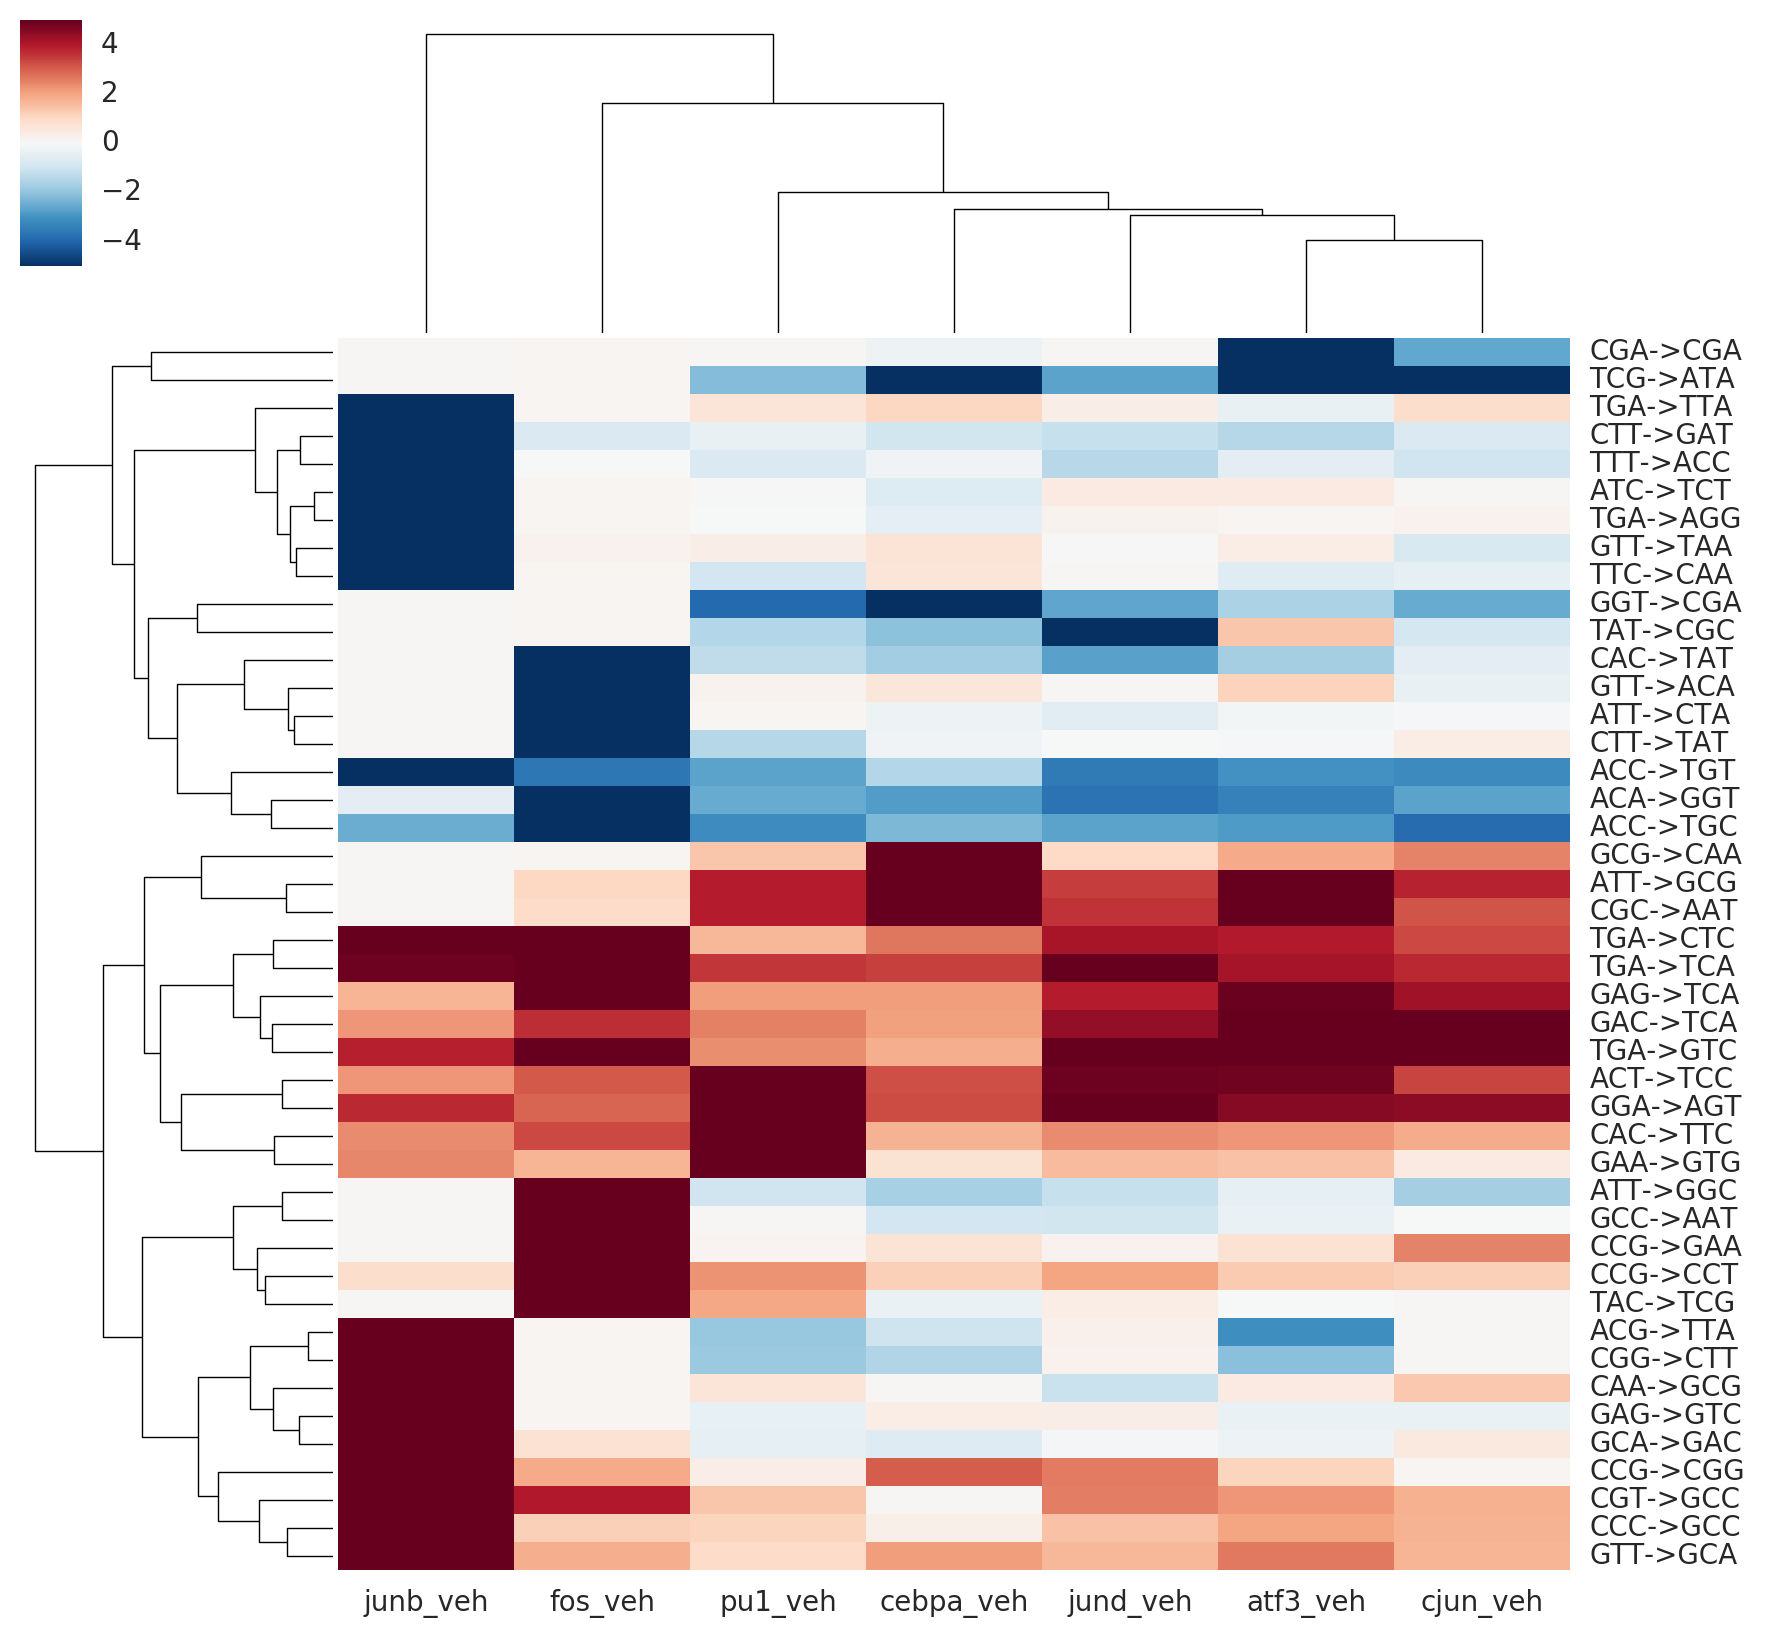

In [475]:
# coefficients_frame = pd.DataFrame(factor_coeff_dict)
# coefficients_frame.index = transition_frame.columns.values
# for col in coefficients_frame.columns.values:
#     sns.distplot(coefficients_frame[col].values, label=col, hist_kws={'alpha':0.2})

# plt.legend()

# # transform_coffcients into z-scores
# coefficients_zscore_frame = coefficients_frame[[]]
# for col in coefficients_frame:
#     coefficients_zscore_frame[col] = scipy.stats.mstats.zscore(coefficients_frame[col].values)

# coefficients_zscore_frame.index = coefficients_frame.index.values
# coefficients_zscore_frame.columns = coefficients_frame.columns.values

### plot coefficents for vehicle
weight_threshold = 5

for treatment in ['veh']:
    data = coefficients_zscore_frame
    data = data[[x for x in coefficients_zscore_frame.columns.values if treatment in x]]
    data = data[(data.max(axis=1) >= weight_threshold) |
                (data.min(axis=1) < -1 * weight_threshold)
                ]
    cg = sns.clustermap(data,
                       vmax=weight_threshold,
                       vmin=-1*weight_threshold,
                       center = 0.0,
                       xticklabels=[x.replace('c57bl6_','') for x in data.columns.values])
    plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), fontsize=10, rotation=0, );

## multiprocessor experiments